## Libraries Importation

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import warnings
warnings.filterwarnings("ignore")

## Dataset importation into analysis environment

In [2]:
df = pd.read_excel("/content/COM6013  DataMining Dataset [2926].xlsx")

## Data Exploration 1

In [3]:
df.head()

,ID,Date,Country(UK),City,Confectionary,Units Sold,Price per Unit (£),Cost per Unit (£),Revenue(£),Cost(£),Profit(£)
0,1038,2023-12-31,Wales,Cardiff,Jelly,1914.0,5.46,2.23,10450.44,4268.22,6182.22
1,1111,2025-12-30,Ireland,Galway,jelly,2382.0,5.34,2.38,12719.88,5669.16,7050.72
2,1742,2025-11-30,Ireland,Cork,Caramel,2943.0,5.30,2.25,15597.90,6621.75,8976.15
3,1060,2025-11-29,England,London,Fudge,1793.0,5.20,2.17,9323.60,3890.81,5432.79
4,116,2025-10-27,Ireland,Galway,jelly,2621.0,4.74,2.30,12423.54,6028.30,6395.24


In [4]:
print(df.shape)

(2000, 11)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  2000 non-null   int64         
 1   Date                2000 non-null   datetime64[ns]
 2   Country(UK)         2000 non-null   object        
 3   City                2000 non-null   object        
 4   Confectionary       2000 non-null   object        
 5   Units Sold          1901 non-null   float64       
 6   Price per Unit (£)  1901 non-null   float64       
 7   Cost per Unit (£)   1901 non-null   float64       
 8   Revenue(£)          2000 non-null   float64       
 9   Cost(£)             2000 non-null   float64       
 10  Profit(£)           2000 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 172.0+ KB


## Data Preprocessing 1

Sorting data by dates

In [6]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)

Ensuring consistency in cases of textual data

In [7]:
df["Country(UK)"] = df["Country(UK)"].astype(str).str.strip().str.title()
df["City"] = df["City"].astype(str).str.strip().str.title()
df["Confectionary"] = df["Confectionary"].astype(str).str.strip().str.title()

Checking and handling misisng values

In [8]:
print( df.isnull().sum())

ID                     0
Date                   0
Country(UK)            0
City                   0
Confectionary          0
Units Sold            99
Price per Unit (£)    99
Cost per Unit (£)     99
Revenue(£)             0
Cost(£)                0
Profit(£)              0
dtype: int64


In [9]:
for col in ["Units Sold", "Price per Unit (£)", "Cost per Unit (£)"]:
    df[col] = df.groupby("Country(UK)")[col].transform(lambda x: x.fillna(x.median()))
    df[col] = df[col].fillna(df[col].median())

## Checking for outliers (EDA and Data preprocesisng)

Ensuring numeric datypes are in right format first

In [10]:
numeric_cols = ["Units Sold", "Price per Unit (£)", "Cost per Unit (£)", "Revenue(£)", "Cost(£)", "Profit(£)"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

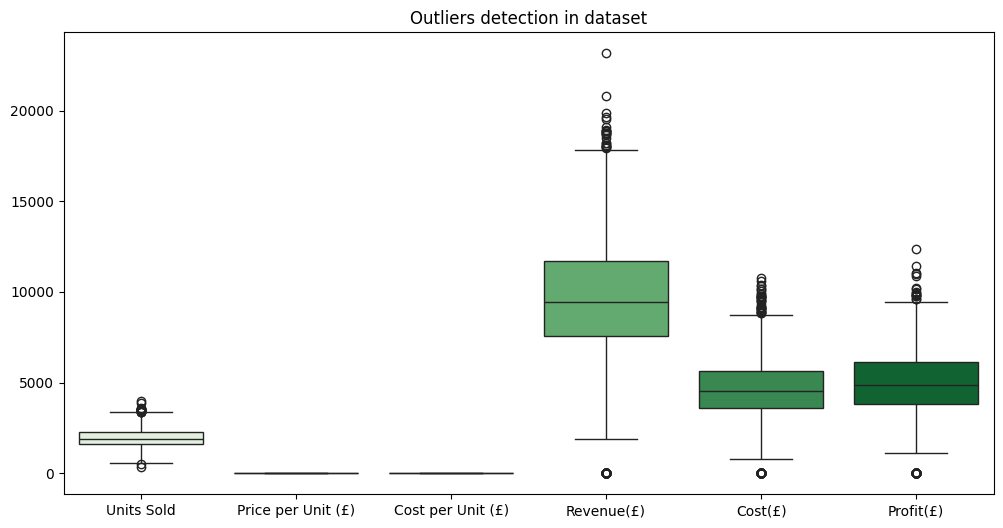

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols],palette="Greens", orient='v')
plt.title("Outliers detection in dataset")
plt.show()

## Handling detected outliers

step 1: Using hierarchical clipping

In [12]:
for col in ["Units Sold", "Price per Unit (£)", "Cost per Unit (£)"]:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = df[col].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

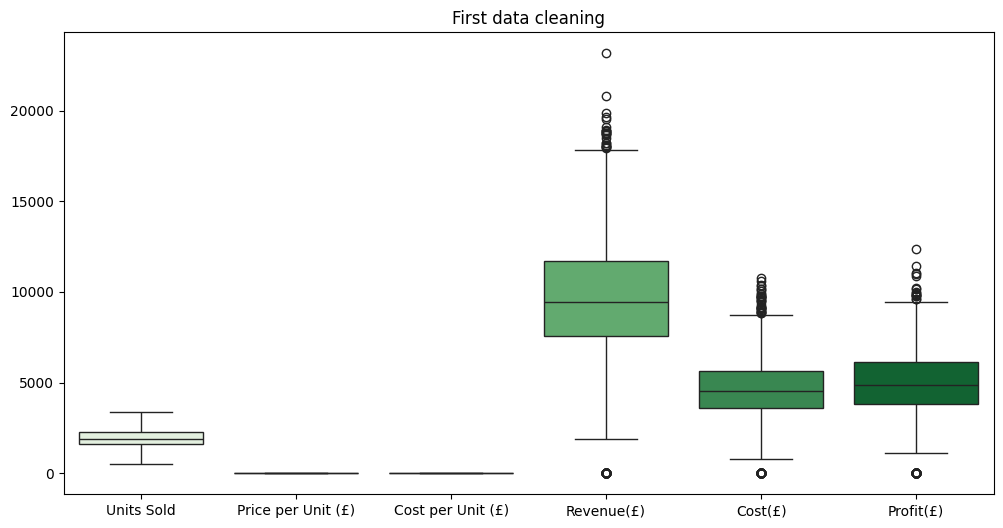

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols], orient="v", palette="Greens")
plt.title("First data cleaning")
plt.show()

Recalculating revenue, cost and profits

In [14]:
df["Revenue(£)"] = df["Units Sold"] * df["Price per Unit (£)"]
df["Cost(£)"] = df["Units Sold"] * df["Cost per Unit (£)"]
df["Profit(£)"] = df["Revenue(£)"] - df["Cost(£)"]

Step 2: Global Outlier Clip

In [15]:
for col in numeric_cols:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = df[col].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

## Visualising data without outliers

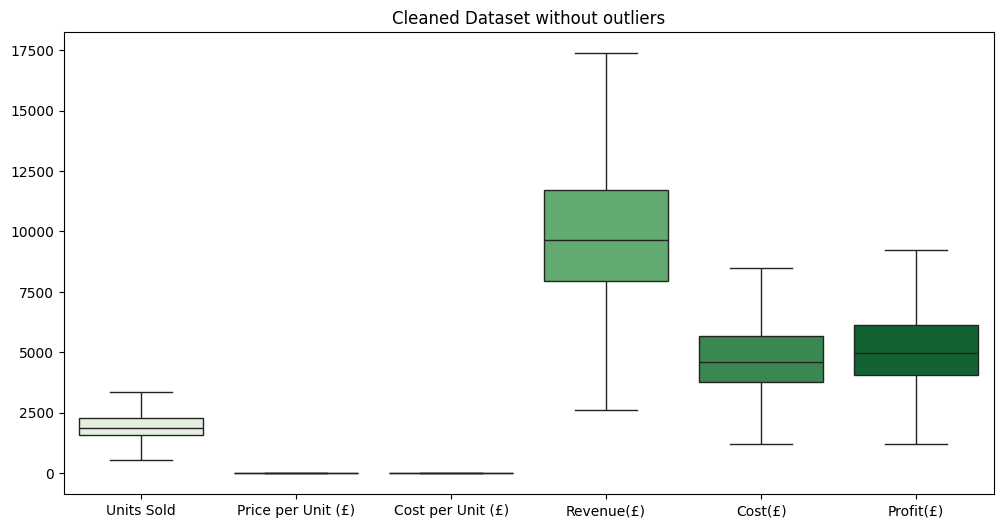

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols], orient="v", palette="Greens")
plt.title("Cleaned Dataset without outliers")
plt.show()

## Descriptive Statistics of the dataset

In [17]:
df=df.drop('ID',axis=1)
df.head()

,Date,Country(UK),City,Confectionary,Units Sold,Price per Unit (£),Cost per Unit (£),Revenue(£),Cost(£),Profit(£)
0,2021-01-01,England,Birmingham,Mint,1276.0,4.450,2.120,5678.20000,2705.12000,2973.08000
1,2021-01-03,Ireland,Galway,Jelly,1922.5,5.105,2.435,9814.36250,4681.28750,5133.07500
2,2021-01-03,Scotland,Edinburgh,Jelly,1454.0,4.420,2.430,6426.68000,3533.22000,2893.46000
3,2021-01-03,Wales,Newport,Caramel,3349.0,5.870,2.950,17369.80625,8481.22375,9233.88375
4,2021-01-05,Scotland,Dundee,Chocolate,1898.0,5.520,2.600,10476.96000,4934.80000,5542.16000


In [18]:
df[numeric_cols].describe()

,Units Sold,Price per Unit (£),Cost per Unit (£),Revenue(£),Cost(£),Profit(£)
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1957.244250,5.094758,2.450042,9955.731788,4783.591681,5163.833766
std,536.846988,0.446569,0.317881,2853.431173,1446.206647,1532.676612
min,533.500000,4.300000,1.740000,2614.150000,1216.380000,1195.840000
25%,1594.000000,4.720000,2.230000,7948.462500,3782.092500,4055.652500
50%,1889.500000,5.080000,2.430000,9662.445000,4600.270000,4973.215000
75%,2301.000000,5.480000,2.660000,11717.000000,5661.745000,6126.945000
max,3361.500000,5.900000,3.280000,17369.806250,8481.223750,9233.883750


## Feature Engineering to create year and month columns in the dataset

In [19]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

## Continious EDA

EDA for profit distribution in the dataset

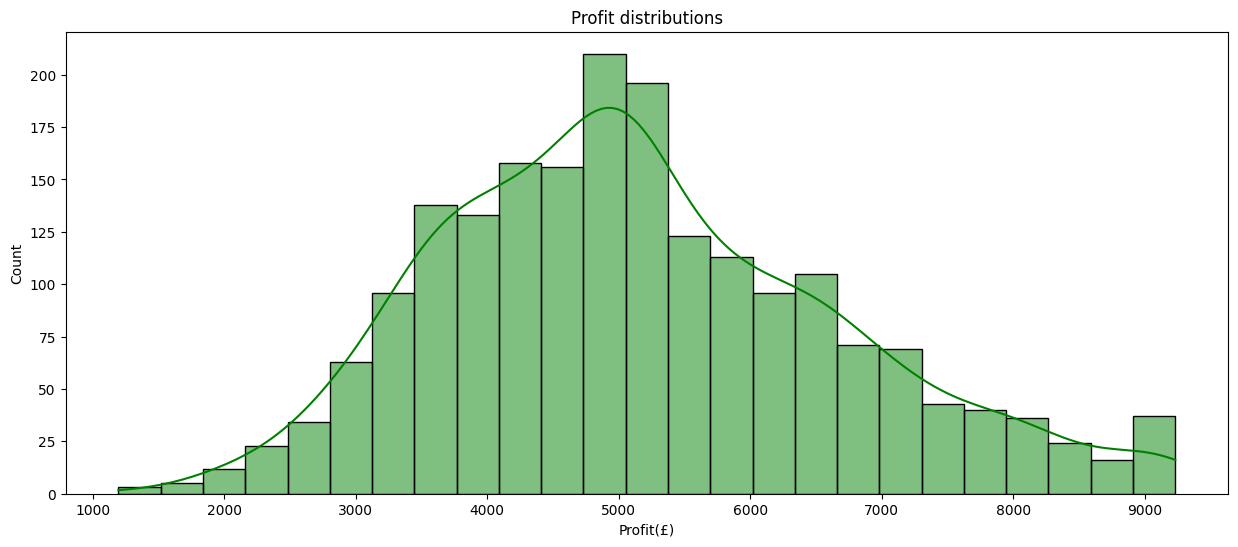

In [20]:
plt.figure(figsize=(15,6))
sns.histplot(df["Profit(£)"], color="green", kde=True)
plt.title("Profit distributions")
plt.show()

EDA: Top 10 cities where profits were most made

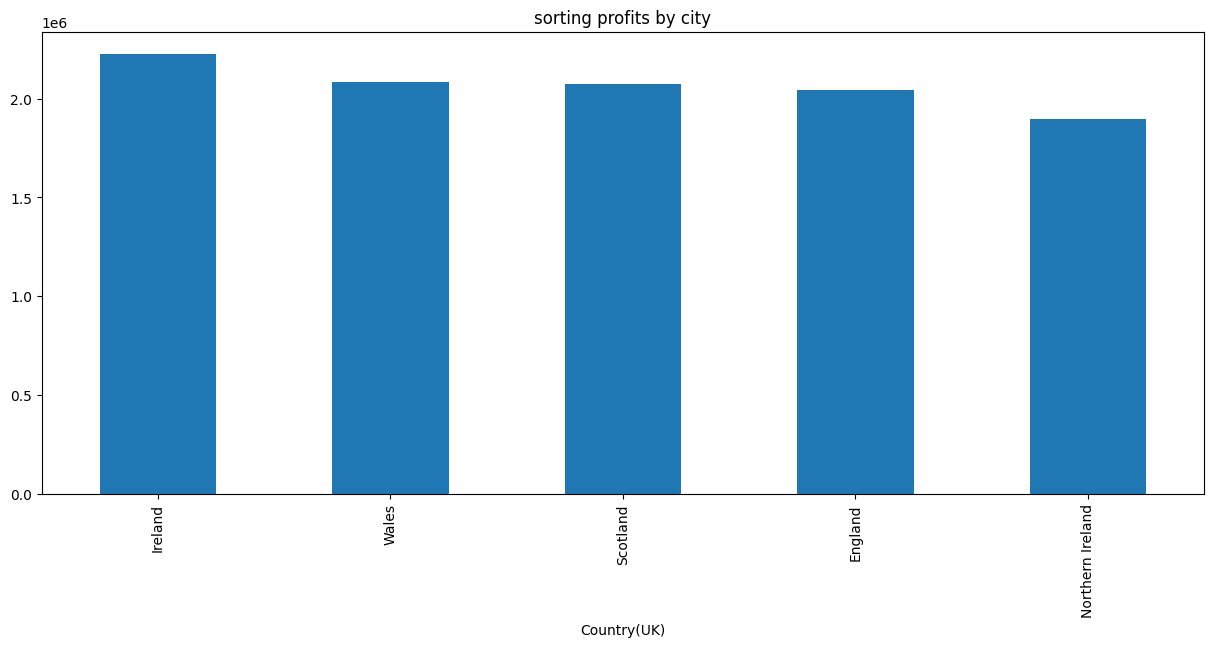

In [21]:
plt.figure(figsize=(15,6))
pro_data=df.groupby("Country(UK)")["Profit(£)"].sum().sort_values(ascending=False)
pro_data.plot(kind="bar")
plt.title("sorting profits by city")
plt.show()

EDA for top 10 cities profit performance

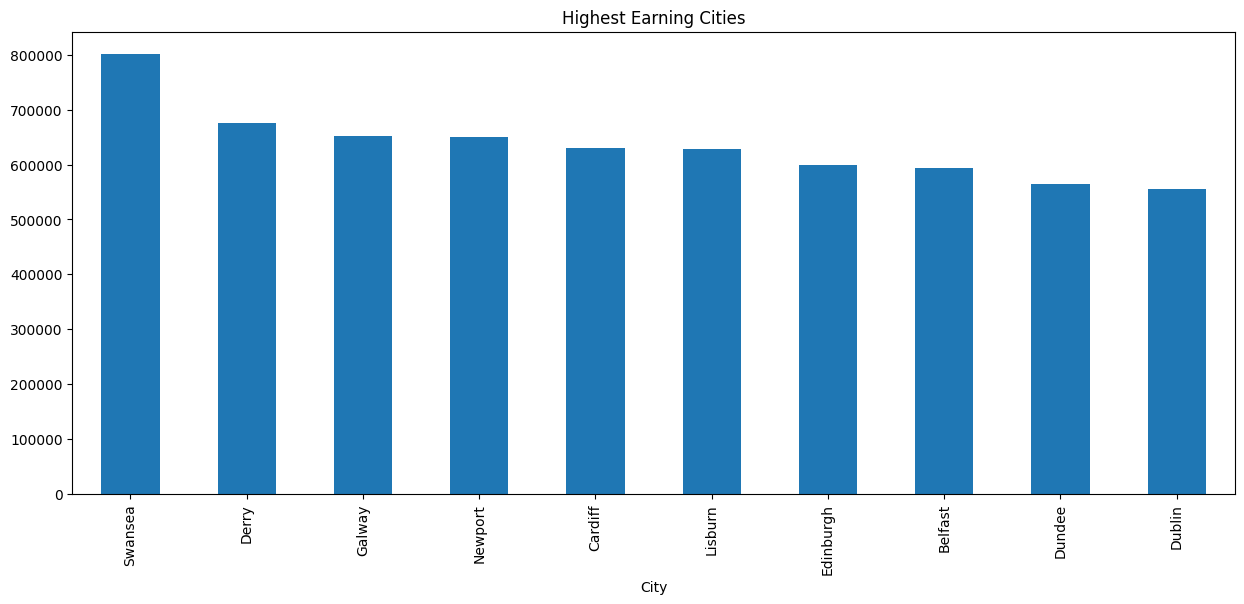

In [22]:
city_data=df.groupby("City")["Profit(£)"].sum().nlargest(10)
plt.figure(figsize=(15,6))
city_data.plot(kind="bar")
plt.title("Highest Earning Cities")
plt.show()

EDA: Confectionary profit Performance

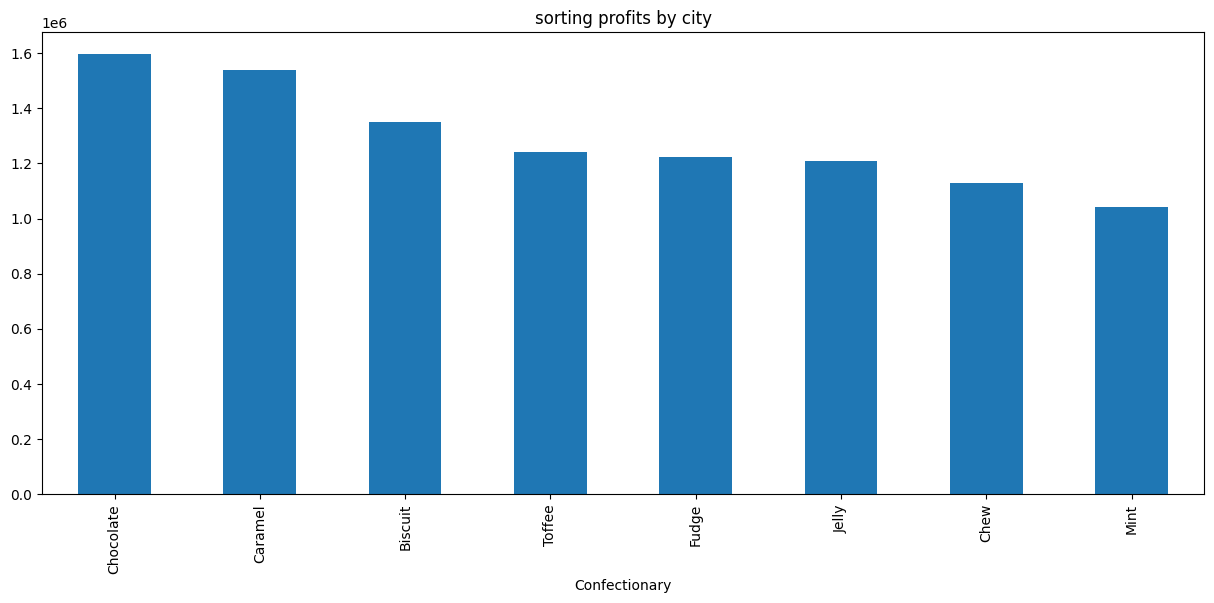

In [23]:
plt.figure(figsize=(15,6))
pro_data=df.groupby("Confectionary")["Profit(£)"].sum().sort_values(ascending=False)
pro_data.plot(kind="bar")
plt.title("sorting profits by city")
plt.show()

EDA: Variable Correlations

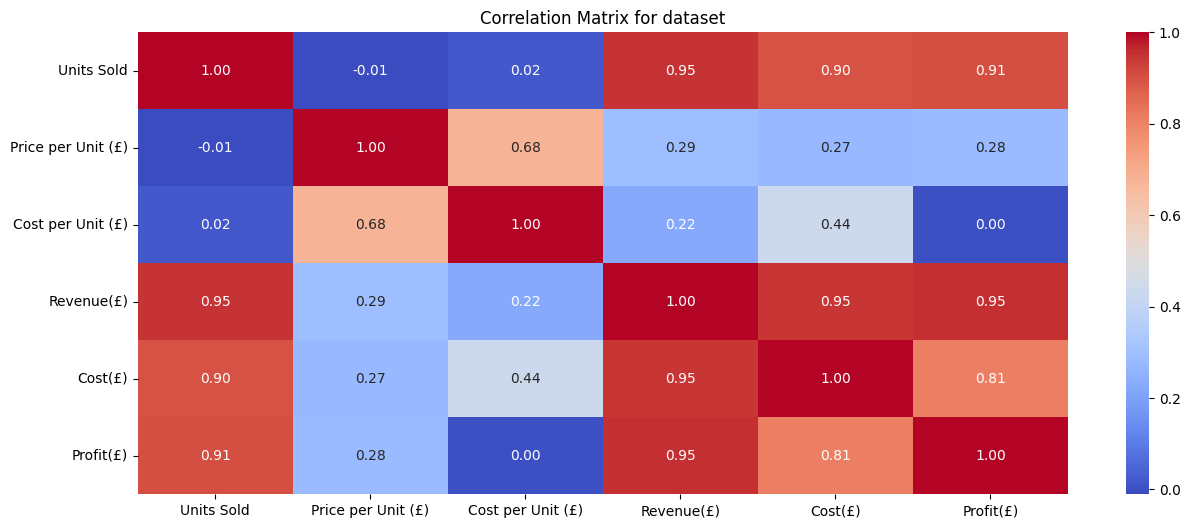

In [24]:
plt.figure(figsize=(15,6));sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Correlation Matrix for dataset")
plt.show()

EDA: Relationship between unit and profits

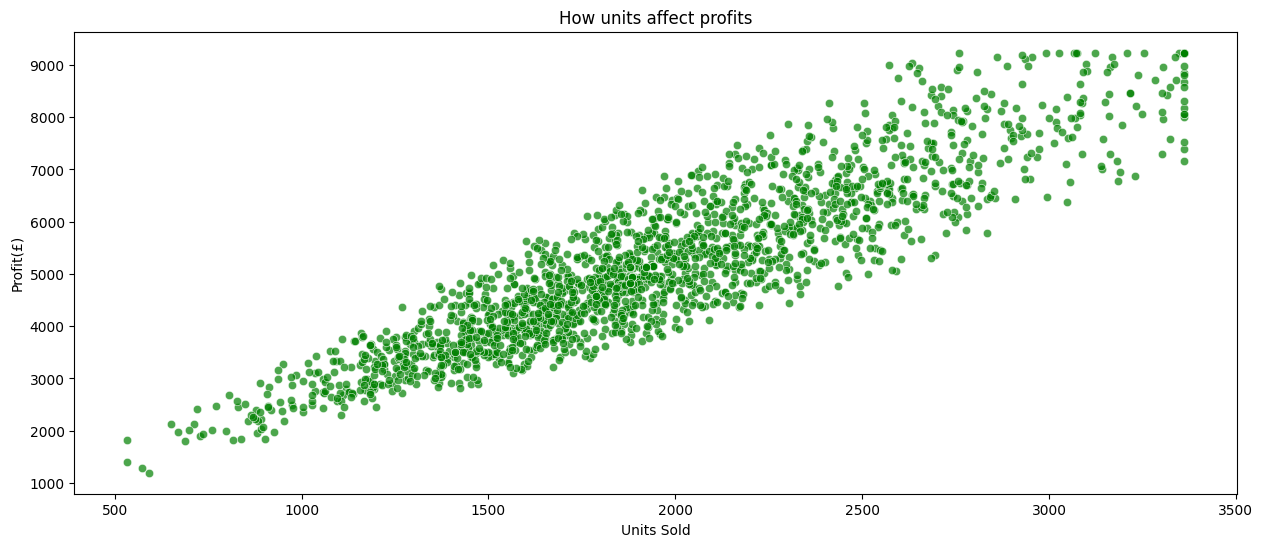

In [25]:
plt.figure(figsize=(15,6));sns.scatterplot(x="Units Sold", y="Profit(£)", data=df, color='green', alpha=0.7)
plt.title("How units affect profits")
plt.show()

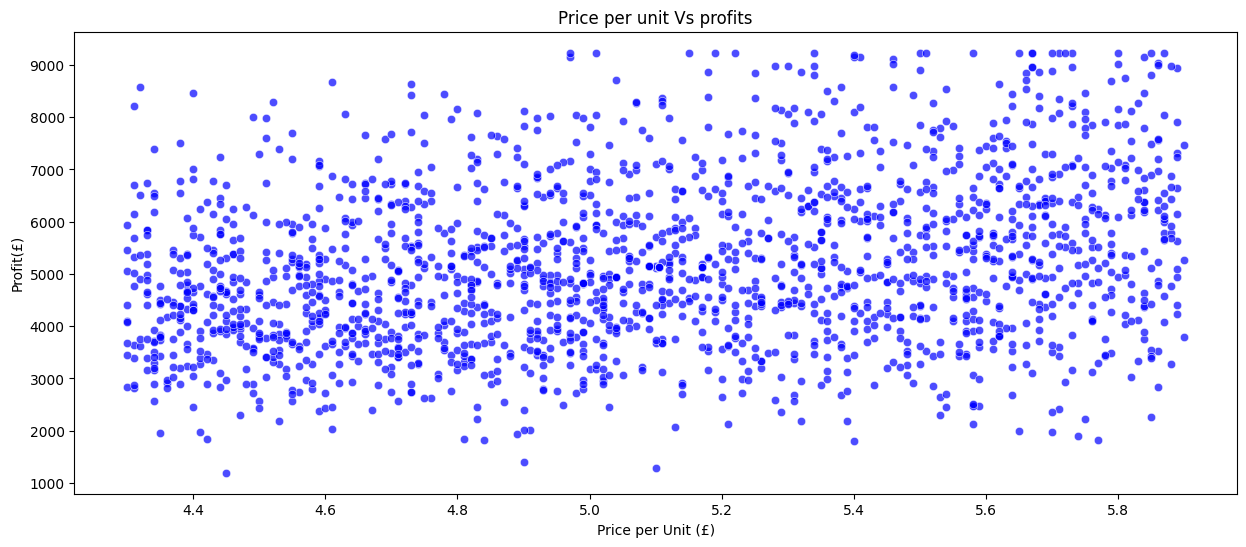

In [26]:
plt.figure(figsize=(15,6));sns.scatterplot(x="Price per Unit (£)", y="Profit(£)", data=df, color='blue', alpha=0.7)
plt.title("Price per unit Vs profits")
plt.show()

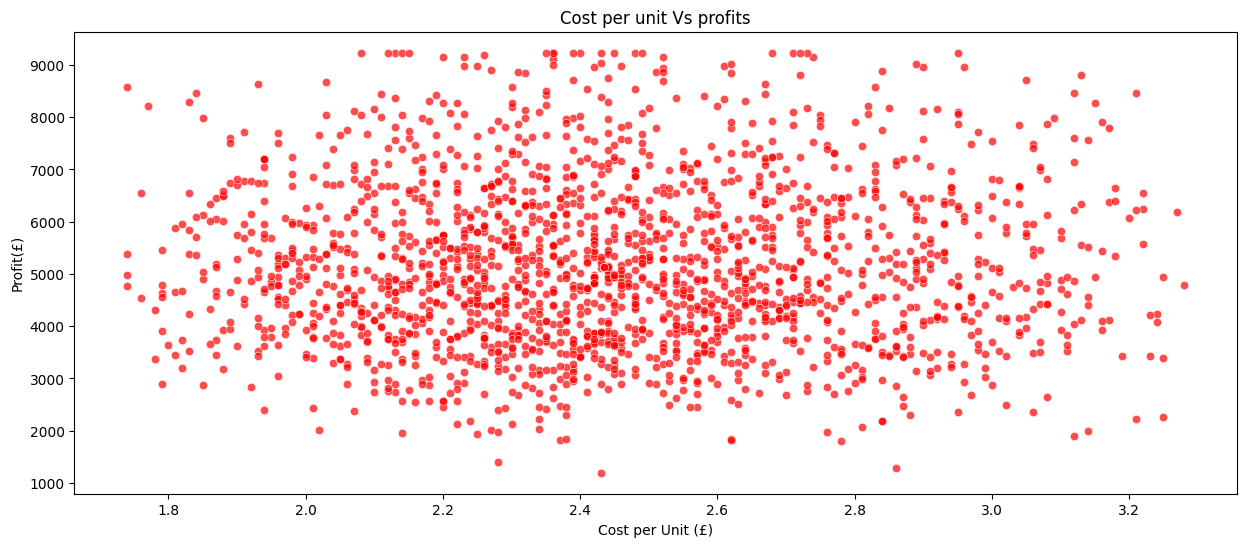

In [27]:
plt.figure(figsize=(15,6));sns.scatterplot(x="Cost per Unit (£)", y="Profit(£)", data=df, color='red', alpha=0.7)
plt.title("Cost per unit Vs profits")
plt.show()

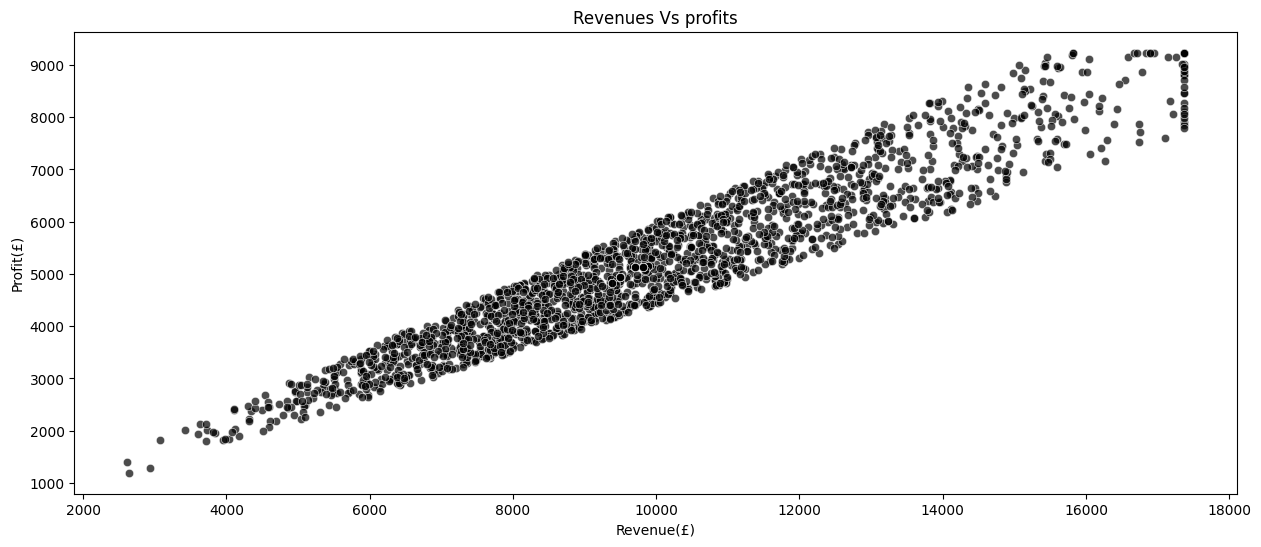

In [28]:
plt.figure(figsize=(15,6));sns.scatterplot(x="Revenue(£)", y="Profit(£)", data=df, color='black', alpha=0.7)
plt.title("Revenues Vs profits")
plt.show()

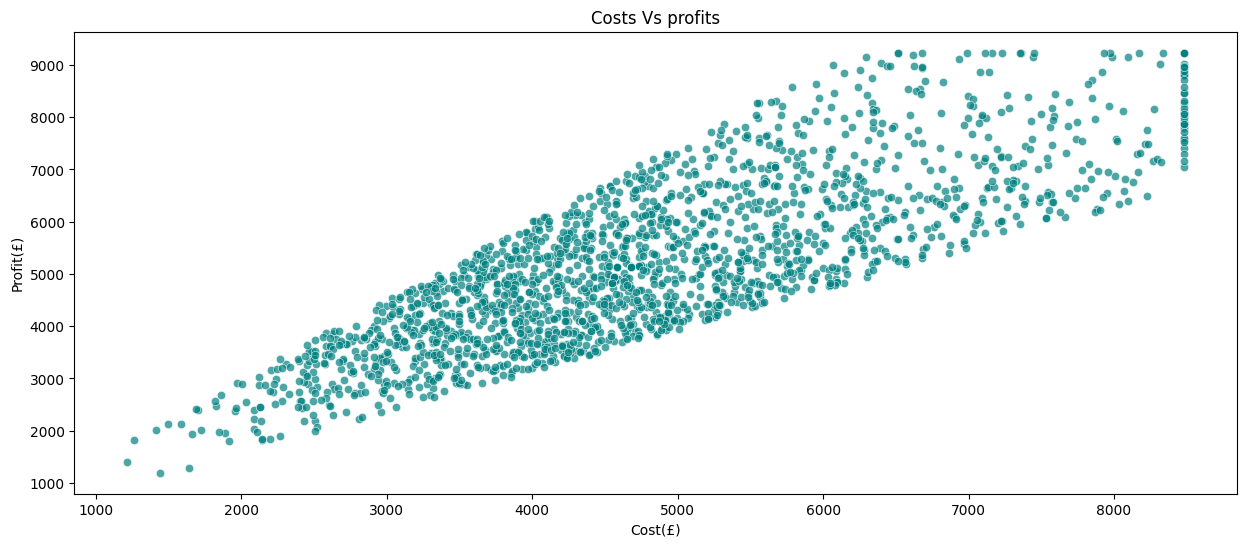

In [29]:
plt.figure(figsize=(15,6));sns.scatterplot(x="Cost(£)", y="Profit(£)", data=df, color='teal', alpha=0.7)
plt.title("Costs Vs profits")
plt.show()

## Time Series Resampling

In [30]:
ts_for_months = df.set_index("Date").resample("MS")["Profit(£)"].sum()
ts_monthly_data = ts_for_months[ts_for_months.index < '2025-12-01']

In [31]:
ts_monthly_data.head(19)

,Profit(£)
Date,
2021-01-01,181472.53875
2021-02-01,157483.83000
2021-03-01,165587.05500
2021-04-01,229115.13000
2021-05-01,151587.42000
2021-06-01,158871.03000
2021-07-01,166668.90000
2021-08-01,114191.31500
2021-09-01,211390.48000


In [32]:
ts_monthly_data.shape

(59,)

## EDA: Monthly Trend for the company

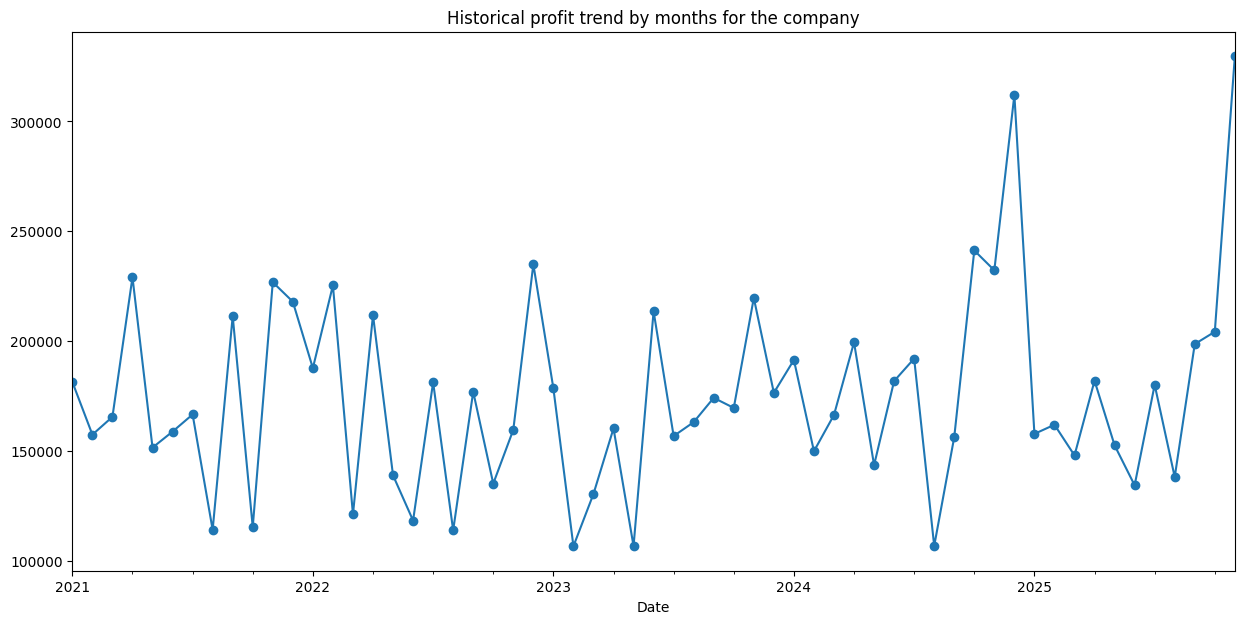

In [33]:
ts_monthly_data.plot(marker='o', figsize=(15,7))
plt.title("Historical profit trend by months for the company")
plt.show()

## EDA: Average profit performance for the company by months(Seasonality)

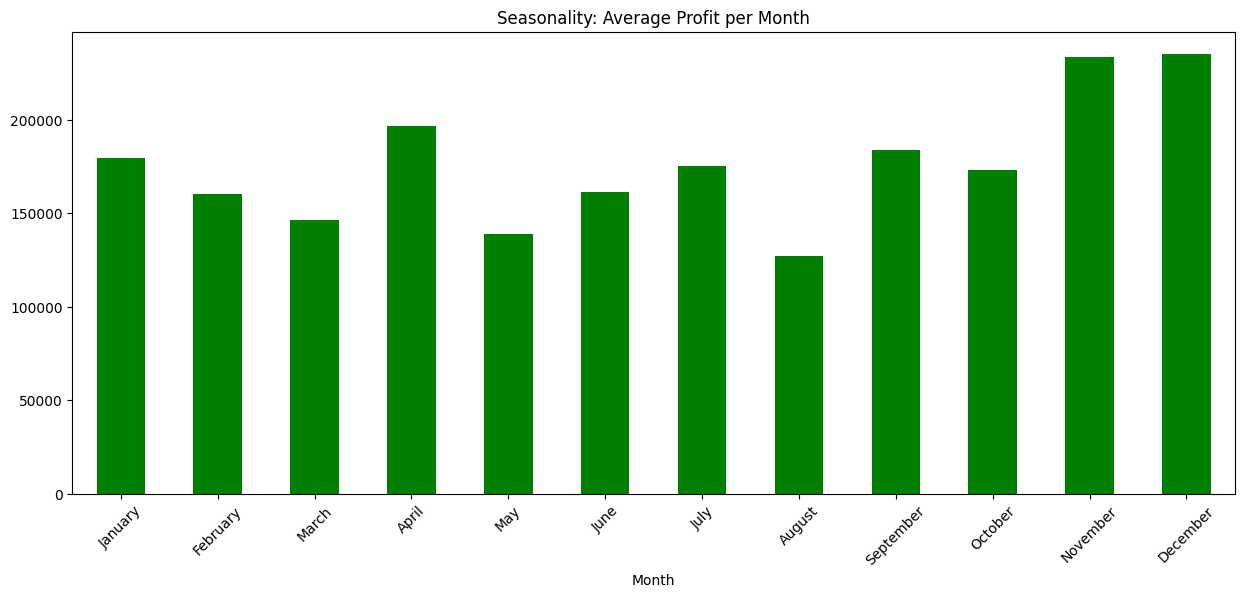

In [34]:
ts_dt_mean = ts_monthly_data.groupby(ts_monthly_data.index.month).mean()
plt.figure(figsize=(15, 6))
ts_dt_mean.plot(kind='bar', color='green')
plt.xticks(ticks=range(0, 12), labels=[calendar.month_name[i] for i in range(1, 13)],  rotation=45)
plt.title("Seasonality: Average Profit per Month")
plt.xlabel("Month")
plt.show()

## EDA: Historical Trends for the 5 countires

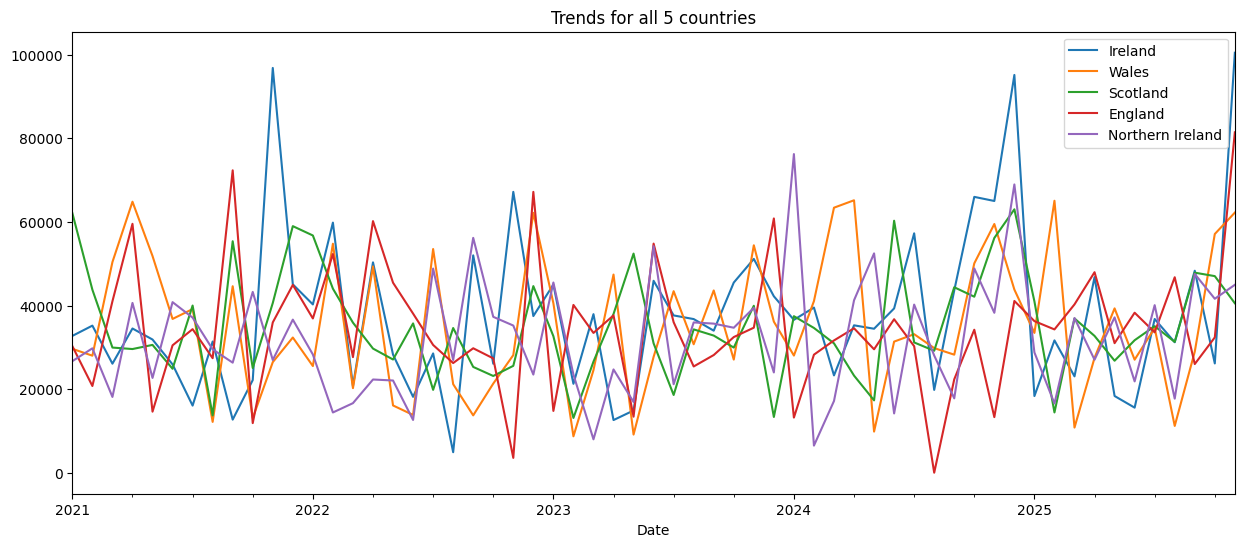

In [35]:
countires = df.groupby("Country(UK)")["Profit(£)"].sum().nlargest(5).index
plt.figure(figsize=(15,6))
for c in countires:
    data = df[df["Country(UK)"] == c].set_index("Date").resample("MS")["Profit(£)"].sum()
    data[data.index < '2025-12-01'].plot(label=c)
plt.title("Trends for all 5 countries")
plt.legend()
plt.show()

## Splititng data for model traning and Testing

In [36]:
train_data = ts_monthly_data.iloc[:-12]
test_data = ts_monthly_data.iloc[-12:]

## Time series model development (Holt-Winters)

In [37]:
ts_model = ExponentialSmoothing(train_data, trend="add", seasonal="mul", seasonal_periods=12)
ts_model=ts_model.fit()
predictions = ts_model.forecast(12)

# Model performance evaluation using MSE, RMSE and MAPE

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_data, predictions)
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

print(f"Model Performance Metrics")
print(f"MAE:   £{round(mae, 2)}")
print(f"RMSE: £{round(rmse, 2)}")
print(f"MAPE:  {round(mape, 2)}%")
print(f"Model Accuracy:{round(100 - mape, 2)}%")

Model Performance Metrics
MAE:   £31135.04
RMSE: £41642.67
MAPE:  15.2%
Model Accuracy:84.8%


model performance validation

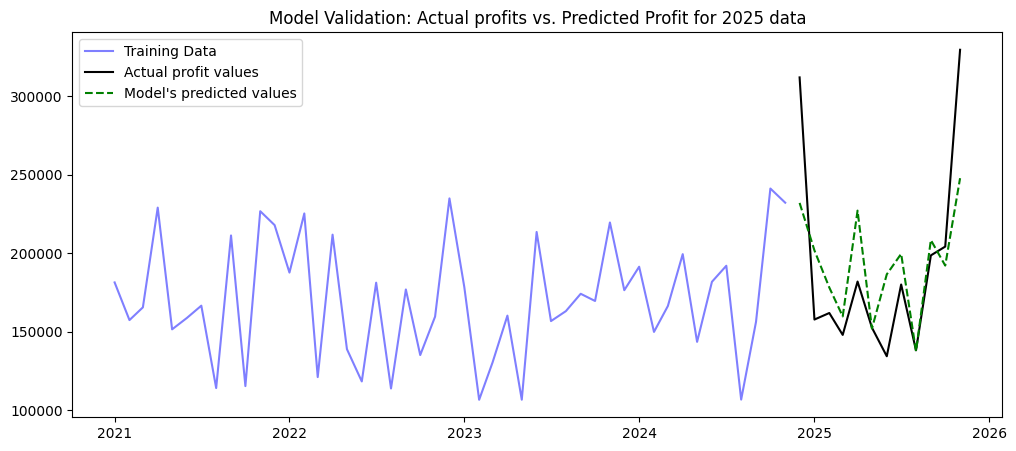

In [39]:
plt.figure(figsize=(12, 5))
plt.plot(train_data, label="Training Data", color="blue", alpha=0.5)
plt.plot(test_data, label="Actual profit values", color="black")
plt.plot(predictions, label="Model's predicted values", linestyle="--", color="green")
plt.title("Model Validation: Actual profits vs. Predicted Profit for 2025 data")
plt.legend()
plt.show()

## Testing model for future Strategic Forecast (Next 6 months)

In [40]:
future_pred = ts_model.forecast(6).round(2)
print("Strategic Profit Projections")
future_pred.name = "Profit Forecast (£)"
future_pred

Strategic Profit Projections


,Profit Forecast (£)
2024-12-01,232119.90
2025-01-01,201826.84
2025-02-01,178221.05
2025-03-01,159826.80
2025-04-01,227213.39
2025-05-01,152113.86


## Residual analysis plot for model

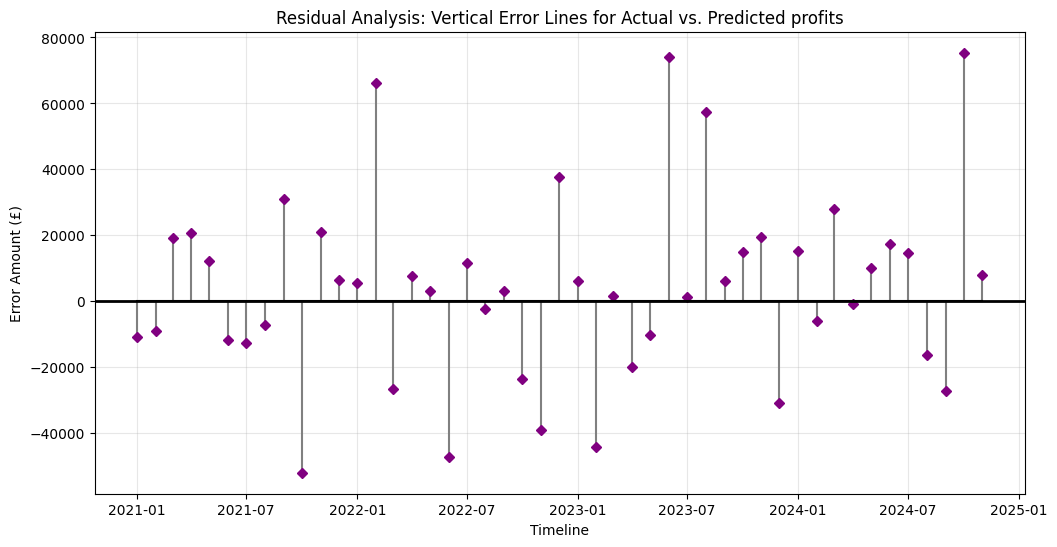

Mean Residual Error value: £4195.17


In [41]:

residual_data = ts_model.resid
plt.figure(figsize=(12, 6))
markerline, stemlines, baseline = plt.stem(residual_data.index, residual_data.values, linefmt='grey', markerfmt='D', basefmt='black')
plt.setp(stemlines, 'linewidth', 1.5)
plt.setp(markerline, 'markersize', 5, 'color', 'purple')
plt.axhline(0, color='black', linewidth=2)
plt.title("Residual Analysis: Vertical Error Lines for Actual vs. Predicted profits")
plt.ylabel("Error Amount (£)");plt.xlabel("Timeline");plt.grid(True, alpha=0.3);plt.show()

print(f"Mean Residual Error value: £{round(residual_data.mean(), 2)}")

Individual Country Projections

In [42]:
country_forecasts = {}

for country in df["Country(UK)"].unique():
    c_data = df[df["Country(UK)"] == country].set_index("Date").resample("MS")["Profit(£)"].sum()
    c_data = c_data[c_data.index < '2025-12-01']
    if len(c_data) >= 24:
        c_model = ExponentialSmoothing(c_data, trend="add", seasonal="add",seasonal_periods=12).fit()
        country_forecasts[country] = c_model.forecast(6)

Regional Growth Comparison Visual

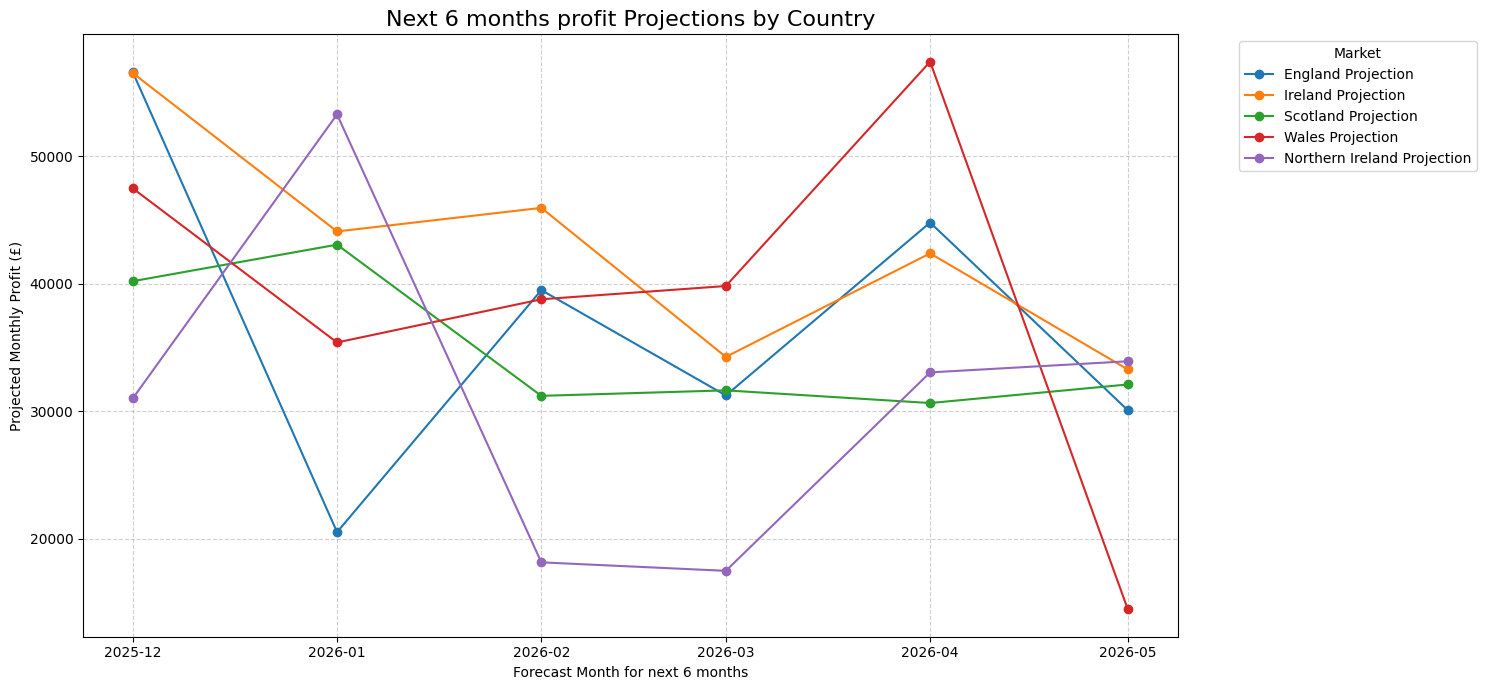

In [43]:
plt.figure(figsize=(15, 7))
for country, forecast_series in country_forecasts.items():
    plt.plot(forecast_series.index, forecast_series.values, marker='o', label=f"{country} Projection")

plt.title("Next 6 months profit Projections by Country", fontsize=16)
plt.ylabel("Projected Monthly Profit (£)")
plt.xlabel("Forecast Month for next 6 months")
plt.legend(title="Market", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()